<a href="https://colab.research.google.com/github/shivang-niranjan/Hyperspectral-imaging/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
import os
import random
from random import shuffle
from skimage.transform import rotate
from tensorflow.keras import utils as np_utils
from sklearn.metrics import classification_report, confusion_matrix
import scipy
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers.legacy import SGD, Adam
import h5py
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')

In [ ]:
def load_data():
    data = sio.loadmat('/content/Indian_pines_corrected.mat')
    labels = sio.loadmat('/content/Indian_pines_gt.mat')
    return data['indian_pines_corrected'], labels['indian_pines_gt']

def splitTrainTestSet(X, y, testRatio=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345, stratify=y)
    return X_train, X_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts
    newX = X[y == uniqueLabels[0], :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :]
    newY = newY[rand_perm]
    return newX, newY

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=1, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            flipped_patch = np.flipud(patch)
        if (num == 1):
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    return X_train

def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats','Soybean-notill', 'Soybean-mintill','Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [ ]:
X, y = load_data()
uniqueLabels, labelCounts = np.unique(y, return_counts=True)
print(labelCounts)

[10776    46  1428   830   237   483   730    28   478    20   972  2455
   593   205  1265   386    93]


In [ ]:
X,pca = applyPCA(X,numComponents=30)
XPatches, yPatches = createPatches(X, y, windowSize= 1)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 0.25)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train = AugmentData(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[3])
y_train = np_utils.to_categorical(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)

<ipython-input-2-c64ce53153bf>:76: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)


In [ ]:
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=3, activation='relu', input_shape = (30,1), padding ='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(16, activation='softmax'))

In [ ]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 20)            80        
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 20)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
Total params: 40672 (158.88 KB)
Trainable params: 40672 (158.88 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
464/464 [==============================] - 2s 4ms/step - loss: 0.6068 - accuracy: 0.7956
Epoch 2/50
464/464 [==============================] - 1s 3ms/step - loss: 0.6026 - accuracy: 0.7965
Epoch 3/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5987 - accuracy: 0.7982
Epoch 4/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5946 - accuracy: 0.7995
Epoch 5/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5910 - accuracy: 0.8002
Epoch 6/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5872 - accuracy: 0.8009
Epoch 7/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5836 - accuracy: 0.8032
Epoch 8/50
464/464 [==============================] - 1s 3ms/step - loss: 0.5800 - accuracy: 0.8038
Epoch 9/50
464/464 [==============================] - 2s 4ms/step - loss: 0.5765 - accuracy: 0.8055
Epoch 10/50
464/464 [==============================] - 2s 4ms/step - loss: 0.5731 - accuracy: 0.8068

In [ ]:
model.save('hyperspectral_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 15.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


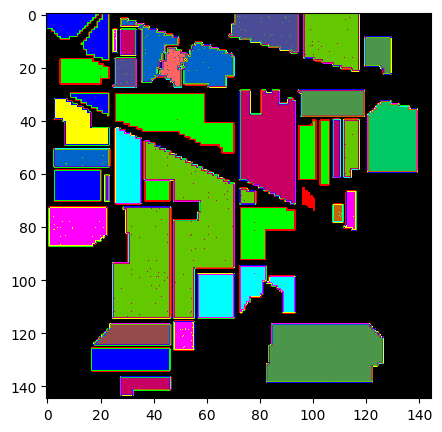

In [ ]:
!pip install spectral
import spectral

ground_truth = spectral.imshow(classes = y,figsize =(5,5))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
numComponents = 30
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 1
X,pca = applyPCA(X,numComponents=numComponents)
print(height,width)

145 145


In [ ]:
patches = []
positions = []
outputs = np.zeros((height,width))

for i in range(height):
    for j in range(width):
        target = int(y[int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            patches.append(image_patch.reshape(1, image_patch.shape[2], image_patch.shape[0]).astype('float32'))
            positions.append((int(i+PATCH_SIZE/2), int(j+PATCH_SIZE/2)))

patches = np.concatenate(patches, axis=0)
predictions = model.predict(patches)
for prediction, position in zip(predictions, positions):
    outputs[position[0]][position[1]] = np.argmax(prediction) + 1

321/321 [==============================] - 1s 3ms/step


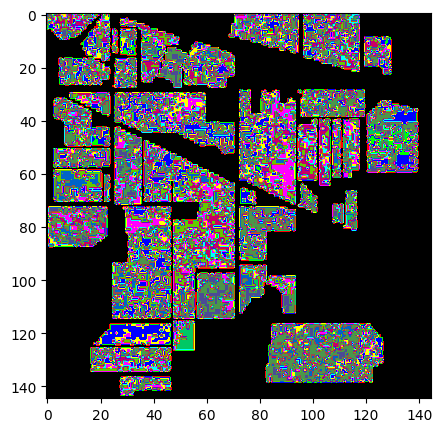

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))